##### Author:
    Diana Y. Lee, Luque Lab, SDSU
    dlee@sdsu.edu

##### Purpose:
    Creates a linear regression model for relating the genome length of a tailed phage to the capsid architecture 
    as measured by the T-number.
    Evaluates the accuracy of that model.
    Creates the base illustrations for Figure 2 of the paper in preparation titled, [TBD]

##### Requires: 
    data\HRphagedata.csv
    
##### Database file: 
    item1_update.db
    
##### Creates:
    Item1-DNA vs T-number(ticks).svg
    Item1-DNA vs T-number.svg
    Item1-DNA vs T model Rarification.svg .png

In [1]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(8)
import math
import copy
import csv
from textwrap import wrap
import statistics
import random

In [2]:
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator,LogLocator)

In [3]:
# regression imports
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import sklearn.metrics
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, explained_variance_score
from scipy.optimize import least_squares

In [5]:
from ipynb.fs.full.phage_functions import tNearest
from ipynb.fs.full.phage_functions import tNearestFloor
from ipynb.fs.full.phage_functions import tNearestValid
from ipynb.fs.full.phage_functions import tModel
from ipynb.fs.full.phage_functions import tNum
from ipynb.fs.full.phage_functions import tList

In [6]:
# set the fontsize
font1 = 24
font2 = 20
font3 = 16

In [7]:
# import data
ogdata = pd.read_csv("data\HRphagedata.csv")

# retrieve x and y
xD = np.asarray(ogdata["DNA (kbp)"]).reshape(-1, 1)
y = np.asarray(ogdata["T"]).reshape(-1, 1)
n = len(xD)

In [8]:
ogdata

,Capsid,T,lattice,h,k,Max Diameter (nm),Family,Reference,NCBI,DNA (bp),DNA (kbp),PDB/ EMDB,packing type,Packed DNA
0,C1,4.00,hex,2,0,50.0,P,Aksyuk et al. (2012),NP_852022,16687,16.687,EMDB 5446,NaN,NaN
1,HSTV-1,7.00,hex,2,1,62.0,P,Pietila et al. (2013),AGC34559,32189,32.189,EMDB 2279,headfull,35440.0
2,P2,7.00,hex,2,1,60.0,M,Dearborn et al. (2012),CAPSD_BPP2,33590,33.590,EMDB 2462,NaN,NaN
3,TP901-1,7.00,hex,2,1,66.0,S,Bebeacua et al. (2013),NP_112699,37667,37.667,EMDB 2133,headfull (pac),38400.0
4,Sf6,7.00,hex,2,1,60.0,P,Parent et al. (2012b),NP_958181,39044,39.044,PDB 5L35,NaN,NaN
5,ε15,7.00,hex,2,1,70.0,P,"Baker et al. (2013), Jiang et al. (2008)",NP_848215,39671,39.671,PDB 3J40,NaN,NaN
6,HK97,7.00,hex,2,1,66.0,S,"Gertsman et al. (2009), Helgstrand et al. (200...",CAPSD_BPHK7,39732,39.732,PDB 2FS3,NaN,NaN
7,T7,7.00,hex,2,1,60.0,P,"Agirrezabala et al. (2007), Guo et al. (2014),...",CAPSA_BPT7,39937,39.937,PDB 1OHG,NaN,NaN
8,CUS-3,7.00,hex,2,1,69.0,P,Parent et al. (2014),ABQ88398,40207,40.207,EMDB 5947,NaN,NaN
9,HK022,7.00,hex,2,1,63.0,S,Pride et al (2006),PRJNA14048,40751,40.751,NaN,NaN,NaN


In [8]:
# function to transform data by looking at log of both independent and dependent variables
def T_power(x,y):
    x_power = np.log(x)
    y_power = np.log(y)
    return x_power, y_power

#power transform 
xD_T1, y_T1=T_power(xD,y)

In [10]:
# create linear regression model
modelD = LinearRegression()
modelD.fit(xD_T1,y_T1)
y_predD = modelD.predict(xD_T1)
n = len(xD_T1)
intD = modelD.intercept_[0]
slopeD = modelD.coef_[0][0]
print('DNA model slope: %.4f' % slopeD)
print('DNA model intercept: %.4f' % intD)

# create linspace for x and y
xlinD = np.linspace(min(xD_T1)-0.1,max(xD_T1)+0.1, 100)
ylinD = slopeD*xlinD+intD

# Predicted values based on regression
print("Mean squared error: %.4f" % mean_squared_error(y_T1, y_predD))
print('R-squared: %.4f' % r2_score(y_T1, y_predD))
print('explained_variance_score: %.4f' % explained_variance_score(y_T1, y_predD))

# Student t-distribution Percent Point Function
# we use critical t, since the error is an estimate

from scipy.stats import t

# CI and degrees of freedom
p = 0.95
df = n-2

# use t.ppdf to retrieve probability
tvalue = t.ppf(p, df)

print('Critical t for', p, 'CI with', df, 'degrees of freedom: %.4f' % tvalue)

# statistics we need to calculate errors

xDmean = np.mean(xD_T1)
xDmse = mean_squared_error(y_T1, y_predD)
# calculate sum of (x-xbar)^2
x_su = 0
for i in xD_T1:
    x_su = x_su + (i-xDmean)**2;

# Calculate error on the slope
# https://newonlinecourses.science.psu.edu/stat501/node/261/
xDslopeErr = tvalue*np.sqrt(xDmse)/np.sqrt(x_su)[0]
print('Error of the slope estimate: %.4f' % xDslopeErr)

# Calculate error on the intercept
xDintErr = tvalue*np.sqrt(xDmse)*np.sqrt(1/n+xDmean**2/x_su)[0]
print('Error of the intercept estimate: %.4f' % xDintErr)

# calculate residuals
e_Res = y_T1 - y_predD

# calculate confidence intervals
DNAr2 = '= ' + str(round(r2_score(y_T1, y_predD),2))
DNAn = 'n = ' + str(n)

DNAf = "ln(T) = (" + str(round(slopeD,2)) + " +/- " + str(round(xDslopeErr,2))+ ")ln(DNA) + (" + str(round(intD,2)) + "+/-"  + str(round(xDintErr,2))+ ") "
DNAf1 = "ln(T) = a(ln(DNA))+b"
DNAfa = "a = " + str(round(slopeD,2)) + " +/- " + str(round(xDslopeErr,2))
DNAfb = "b = " + str(round(intD,2)) + " +/- "  + str(round(xDintErr,2))

DNAfa1 = "a = " + str(round(slopeD,2))
DNAfa2 = str(round(xDslopeErr,2))
DNAfb1 = "b = " + str(round(intD,2))
DNAfb2 = str(round(xDintErr,2))

MRE = np.mean(abs(np.exp(y_predD)-y_T1)/y_T1)
MeanRE= "Mean Relative Error: " + str(round(MRE,4))
print(MeanRE)

tModel = [slopeD, xDslopeErr, intD, xDintErr]

DNA model slope: 0.7127
DNA model intercept: -0.7178
Mean squared error: 0.0104
R-squared: 0.9724
explained_variance_score: 0.9724
Critical t for 0.95 CI with 35 degrees of freedom: 1.6896
Error of the slope estimate: 0.0333
Error of the intercept estimate: 0.1471
Mean Relative Error: 3.9996


In [6]:
tModel

[0.7126674068553558,
 0.03333730632508702,
 -0.7177820291034642,
 0.14705596119972542]

In [10]:
# calculate naive confidence intervals
ylinDmax = ylinD+0.083*ylinD
ylinDmin = ylinD-0.083*ylinD

In [11]:
xlinD2 = []
for i in range(len(xlinD)):
    xlinD2.append(xlinD[i][0])
np.asarray(xlinD2)
xlinD = xlinD2

ylinDmax2 = []
for i in range(len(ylinDmax)):
    ylinDmax2.append(ylinDmax[i][0])
np.asarray(ylinDmax2)
ylinDmax = ylinDmax2

ylinDmin2 = []
for i in range(len(ylinDmin)):
    ylinDmin2.append(ylinDmin[i][0])
np.asarray(ylinDmin2)
ylinDmin = ylinDmin2

In [12]:
from ipynb.fs.full.phage_functions import tList
#create a list of possible, valid T-numbers, as well as separate t-number lists for T_h and T_t 
tps2, tps, tps_t, tps_h = tList(10)
tps2 = list(filter(lambda x: (x <= 52 and x >= 3), tps2)) 

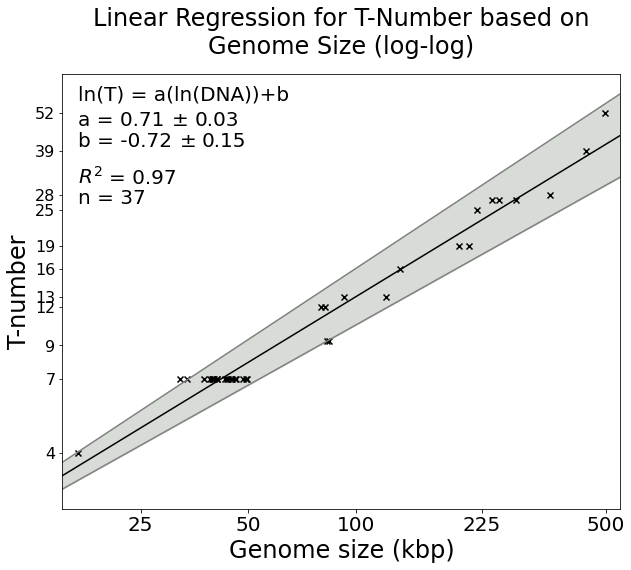

In [13]:
# plot naive confidence intervals based on mean relative error

#plot model 1

# create alternate x & y tick labels
dList = [25, 50, 100, 225, 500]
tList = [4,  7,  9, 12, 13, 16, 19, 25, 28, 39, 52]
      
dLog = np.log(dList)
tLog = np.log(tList)

# plotting steps
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
ax.set_facecolor('xkcd:white')
#fig.patch.set_facecolor('xkcd:light gray')
plt.fill_between(xlinD, ylinDmax, ylinDmin, color='xkcd:light gray')
plt.plot(xlinD, ylinD, color="black")
plt.plot(xlinD, ylinDmax, color="gray")
plt.plot(xlinD, ylinDmin, color="gray")
plt.scatter(xD_T1,y_T1, color="black", marker="x")
ax.set_title("\n".join(wrap("Linear Regression for T-Number based on Genome Size (log-log)", 40)), fontsize=font1, pad=20)
plt.xlim((min(xD_T1)-.1,max(xD_T1)+.1))
plt.ylabel("T-number", fontsize=font1)
plt.xlabel("Genome size (kbp)", fontsize=font1)
plt.text(min(xD_T1), max(ylinDmax)-.05, DNAf1, {'fontsize': font2})
plt.text(min(xD_T1), max(ylinDmax)-.24, DNAfa1, {'fontsize': font2})
plt.text(min(xD_T1)+.6, max(ylinDmax)-.24, (r'$\pm$'), {'fontsize': font2})
plt.text(min(xD_T1)+.75, max(ylinDmax)-.24, DNAfa2, {'fontsize': font2})
plt.text(min(xD_T1), max(ylinDmax)-.4, DNAfb1, {'fontsize': font2})
plt.text(min(xD_T1)+.65, max(ylinDmax)-.4, (r'$\pm$'), {'fontsize': font2})
plt.text(min(xD_T1)+.8, max(ylinDmax)-.4, DNAfb2, {'fontsize': font2})
plt.text(min(xD_T1), max(ylinDmax)-.68, (r'$R^2$') , {'fontsize': font2})
plt.text(min(xD_T1)+.2, max(ylinDmax)-.68, DNAr2 , {'fontsize': font2})
plt.text(min(xD_T1), max(ylinDmax)-.83, DNAn, {'fontsize': font2})
plt.yticks(tLog, tList, fontsize=font3)
plt.xticks(dLog, dList, fontsize=font2);


From Kutner et al:

The MSE is calculated by:
$$ MSE = \frac{SSE}{n-2} = \frac{\sum_{i=1}^n(y_i-\hat{y}_i)^2}{n-2}  $$

The estimated variance $s$ at each point $x_h$ is calculated by:
$$ s^2\{y_h\} = MSE \left(\frac{1}{n} + \frac{(x_h-\bar{x})^2}{\sum(x_h-\bar{x})^2} \right)  $$

Both are necessary for calculating the Working-Hotelling Confidence Band at $1-\alpha$, which has the following boundary values at any $x_h$:

$$\hat{y}_h \pm Ws\{\hat{y}_h\}$$

where
$$W^2 = 2F(1-\alpha; 2, n-2)$$

and where F is the f statistic

In [14]:
# https://stattrek.com/online-calculator/f-distribution.aspx
# f(1-alpha; 2,n-2), here 1-alpha = .95 and n = 35
fstat = 3.29
W = np.sqrt(2*fstat)
W

2.565151067676132

In [15]:
# set n
n = len(xD_T1)

# calculate the sum of squared errors
sse = 0
for i in range(n):
    sse = sse + (y_T1[i]-y_predD[i])**2

# then use it to calculate the MSE
mse = (sse/(n-2))[0] 
mse
# good; matches built-in python calculation above

0.010967159671527157

In [16]:
# calculate the mean x
x_mean = np.mean(xD_T1)

# calculate the sum of differences in xh - xbar
ss_xm = 0
for i in range(n):
    ss_xm = ss_xm + (xD_T1[i]-x_mean)**2
ss_xm

array([26.64729416])

In [17]:
# calculate the variance at each x_h
var_s = []
for i in range(n):
    var_s.append((np.sqrt(mse*(1/n+((xD_T1[i]-x_mean)**2)/(ss_xm))))[0])
#var_s

In [18]:
# use the variance and W to calculate the working-hotelling boundaries
# and reduce the degree of the arrays of x and y to make plotting cleaner

#x values
xlinDw = []
#y predicted
ylinDw = []
# working-hotelling values
ylinD_WH = []
for i in range(n):
    xlinDw.append(xD_T1[i][0])
    ylinDw.append(y_predD[i][0])
    ylinD_WH.append(W*var_s[i])

xlinDw = np.asarray(xlinDw)
ylinDw = np.asarray(ylinDw)
ylinD_WH = np.asarray(ylinD_WH)

# make the upper and lower y value arrays
ylinDmax = ylinDw+ylinD_WH
ylinDmin = ylinDw-ylinD_WH

In [19]:
np.exp(np.log(82)*.71-.72)

11.120282192875786

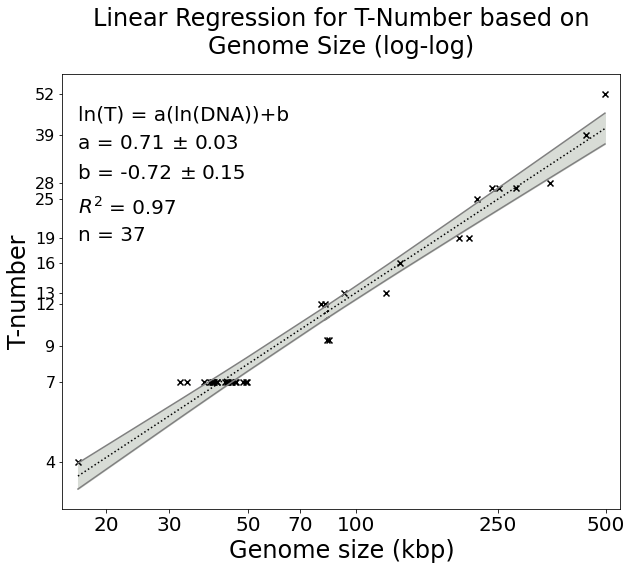

In [20]:
#plot model 1

# create alternate x & y tick labels
dList = [20, 30, 50, 70, 100, 250, 500]
tList = [4,  7,  9, 12, 13, 16, 19, 25, 28, 39, 52]
      
dLog = np.log(dList)
tLog = np.log(tList)

# plotting steps
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
ax.set_facecolor('xkcd:white')
#fig.patch.set_facecolor('xkcd:light gray')
plt.fill_between(xlinDw, ylinDmax, ylinDmin, color='xkcd:light gray')
plt.plot(xlinDw, ylinDw, color="black", linestyle=":")
plt.plot(xlinDw, ylinDmax, color="gray")
plt.plot(xlinDw, ylinDmin, color="gray")
plt.scatter(xD_T1,y_T1, color="black", marker="x")
ax.set_title("\n".join(wrap("Linear Regression for T-Number based on Genome Size (log-log)", 40)), fontsize=font1, pad=20)
plt.xlim((min(xD_T1)-.1,max(xD_T1)+.1))
plt.ylabel("T-number", fontsize=font1)
plt.xlabel("Genome size (kbp)", fontsize=font1)
plt.text(min(xD_T1), max(ylinDmax)-.05, DNAf1, {'fontsize': font2})
plt.text(min(xD_T1), max(ylinDmax)-.25, DNAfa1, {'fontsize': font2})
plt.text(min(xD_T1)+.6, max(ylinDmax)-.25, (r'$\pm$'), {'fontsize': font2})
plt.text(min(xD_T1)+.75, max(ylinDmax)-.25, DNAfa2, {'fontsize': font2})
plt.text(min(xD_T1), max(ylinDmax)-.46, DNAfb1, {'fontsize': font2})
plt.text(min(xD_T1)+.65, max(ylinDmax)-.46, (r'$\pm$'), {'fontsize': font2})
plt.text(min(xD_T1)+.8, max(ylinDmax)-.46, DNAfb2, {'fontsize': font2})
plt.text(min(xD_T1), max(ylinDmax)-.7, (r'$R^2$') , {'fontsize': font2})
plt.text(min(xD_T1)+.2, max(ylinDmax)-.7, DNAr2 , {'fontsize': font2})
plt.text(min(xD_T1), max(ylinDmax)-.89, DNAn, {'fontsize': font2})
plt.yticks(tLog, tList, fontsize=font3)
plt.xticks(dLog, dList, fontsize=font2)


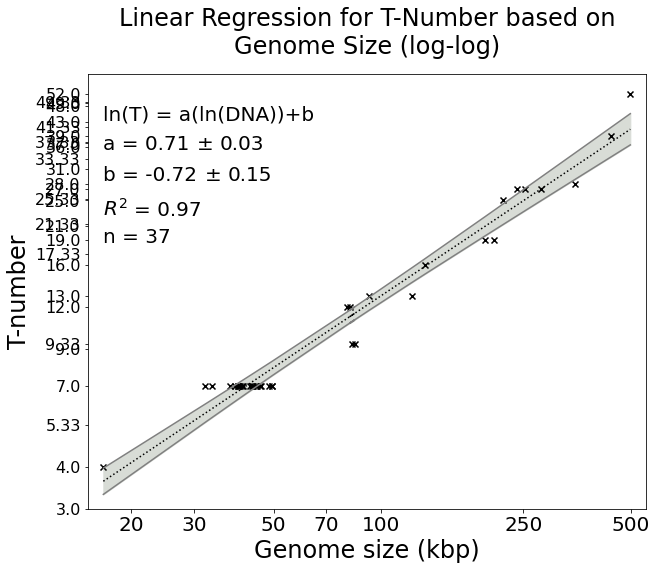

In [21]:
#plot model 1 with ticks for all possible T-numbers

# create alternate x & y tick labels
dList = [20, 30, 50, 70, 100, 250, 500]
#tList = [4,  7,  9, 12, 13, 16, 19, 25, 28, 39, 52]
tList = tps2
      
dLog = np.log(dList)
tLog = np.log(tList)

# plotting steps
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
ax.set_facecolor('xkcd:white')
#fig.patch.set_facecolor('xkcd:light gray')
plt.fill_between(xlinDw, ylinDmax, ylinDmin, color='xkcd:light gray')
plt.plot(xlinDw, ylinDw, color="black", linestyle=":")
plt.plot(xlinDw, ylinDmax, color="gray")
plt.plot(xlinDw, ylinDmin, color="gray")
plt.scatter(xD_T1,y_T1, color="black", marker="x")
ax.set_title("\n".join(wrap("Linear Regression for T-Number based on Genome Size (log-log)", 40)), fontsize=font1, pad=20)
plt.xlim((min(xD_T1)-.1,max(xD_T1)+.1))
plt.ylim(max(ylinDw)+.05)
plt.ylabel("T-number", fontsize=font1)
plt.xlabel("Genome size (kbp)", fontsize=font1)
plt.text(min(xD_T1), max(ylinDmax)-.05, DNAf1, {'fontsize': font2})
plt.text(min(xD_T1), max(ylinDmax)-.25, DNAfa1, {'fontsize': font2})
plt.text(min(xD_T1)+.6, max(ylinDmax)-.25, (r'$\pm$'), {'fontsize': font2})
plt.text(min(xD_T1)+.75, max(ylinDmax)-.25, DNAfa2, {'fontsize': font2})
plt.text(min(xD_T1), max(ylinDmax)-.46, DNAfb1, {'fontsize': font2})
plt.text(min(xD_T1)+.65, max(ylinDmax)-.46, (r'$\pm$'), {'fontsize': font2})
plt.text(min(xD_T1)+.8, max(ylinDmax)-.46, DNAfb2, {'fontsize': font2})
plt.text(min(xD_T1), max(ylinDmax)-.7, (r'$R^2$') , {'fontsize': font2})
plt.text(min(xD_T1)+.2, max(ylinDmax)-.7, DNAr2 , {'fontsize': font2})
plt.text(min(xD_T1), max(ylinDmax)-.89, DNAn, {'fontsize': font2})
plt.yticks(tLog, tList, fontsize=font3)
plt.xticks(dLog, dList, fontsize=font2)
 
fig.savefig("Item1-DNA vs T-number(ticks).svg")


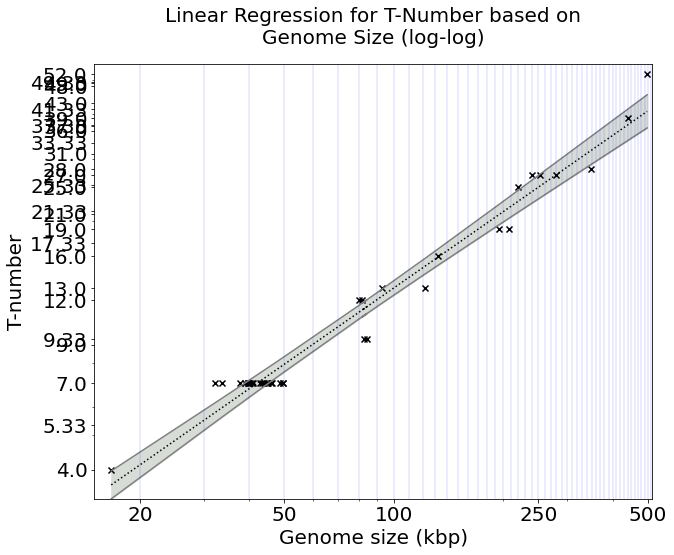

In [22]:
# plot model #1 with ticks for all T-numbers and log lines

# calculate plot limits
xlinDw2=np.exp(xlinDw)
ylinDw2=np.exp(ylinDw)
ylinDmax2=np.exp(ylinDmax)
ylinDmin2=np.exp(ylinDmin)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
ax.set_facecolor('xkcd:white')
ax.fill_between(xlinDw2, ylinDmax2, ylinDmin2, color='xkcd:light gray')
ax.plot(xlinDw2, ylinDw2, color="black", linestyle=":")
ax.plot(xlinDw2, ylinDmax2, color="gray")
ax.plot(xlinDw2, ylinDmin2, color="gray")
ax.scatter(np.exp(xD_T1),np.exp(y_T1), color="black", marker="x")
ax.set_title("\n".join(wrap("Linear Regression for T-Number based on Genome Size (log-log)", 40)), fontsize=font2, pad=20)
ax.set_ylabel("T-number", fontsize=font2)
ax.set_xlabel("Genome size (kbp)", fontsize=font2)

ax.set_yscale('log')
ax.set_xscale('log')

# create alternate x & y tick labels
dList = [20, 50, 100, 250, 500]
#tList = [4,  7,  9, 12, 13, 16, 19, 25, 28, 39, 52]
tList = tps2

plt.yticks(tList, tList, fontsize=font2)
plt.xticks(dList, dList, fontsize=font2)

ybot=np.exp(np.min(ylinDmin))
ytop=np.exp(np.max(ylinDmax)+.2)
ax.set_ylim(ybot, ytop)
xbot = 15
xtop = 515
ax.set_xlim(xbot, xtop)

yt_range = np.linspace(ybot,ytop,2)
for xtr in range(60):
    xt_range = np.linspace(10*xtr,10*xtr,2)
    plt.plot(xt_range,yt_range,alpha=0.1,color='blue')

fig.savefig("Item1-DNA vs T-number.svg")



n -- mean -- var -- std dev -- std err
[[5.00000000e+00 1.13646239e-01 2.10215261e-03 4.58469454e-02
  4.58469454e-04]
 [6.00000000e+00 1.06193696e-01 1.22474014e-03 3.49945377e-02
  3.49945377e-04]
 [7.00000000e+00 1.01231606e-01 7.89604802e-04 2.80985025e-02
  2.80985025e-04]
 [8.00000000e+00 9.84860768e-02 4.73032187e-04 2.17482156e-02
  2.17482156e-04]
 [9.00000000e+00 9.64433976e-02 3.21702338e-04 1.79351657e-02
  1.79351657e-04]
 [1.00000000e+01 9.50879808e-02 2.62023461e-04 1.61863294e-02
  1.61863294e-04]
 [1.10000000e+01 9.40359157e-02 1.78469541e-04 1.33585813e-02
  1.33585813e-04]
 [1.20000000e+01 9.30428558e-02 1.32190730e-04 1.14968479e-02
  1.14968479e-04]
 [1.30000000e+01 9.25390425e-02 1.34426957e-04 1.15936842e-02
  1.15936842e-04]
 [1.40000000e+01 9.19016280e-02 1.34067747e-04 1.15781838e-02
  1.15781838e-04]
 [1.50000000e+01 9.13613656e-02 1.31394069e-04 1.14621521e-02
  1.14621521e-04]
 [1.60000000e+01 9.09459213e-02 1.28570307e-04 1.13383178e-02
  1.13383178e-04]
 

Text(0.5, 0, 'Number of data points')

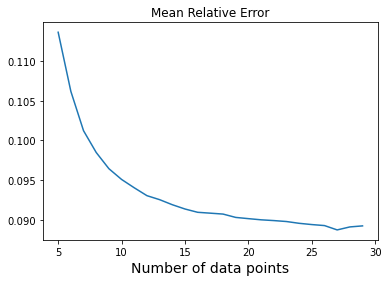

In [23]:
# rarification model: for a given x,y dataset, we begin with a very small training group (5), with the remainder 
# used as the test group (n-5) and gather statistical accuracy information over a large number of runs
# then, we increase the training group by 5 and repeat 
# this time looking at the mean relative error at each point (abs(ypred-ytrue)/ytrue)


n = len(xD_T1)
n_iter = len(np.arange(5,n-7))
n_subiter = 10000

D_err = np.zeros((n_iter,5))
shuffle_index = np.random.permutation(n)

for i in range(n_iter):
    nsub = i+5
    D_err2 = np.zeros((n_subiter,1))

    for j in range(n_subiter):
        # create a random shuffle of the phage table data
        shuffle_index = np.random.permutation(shuffle_index)
        xDshuf, yShuf, yTrueShuf= xD_T1[shuffle_index], y_T1[shuffle_index], y[shuffle_index]

        xD_train, xD_test = xDshuf[:nsub], xDshuf[nsub:]
        y_train, y_test = yShuf[:nsub], yShuf[nsub:]
        yTrue_train, yTrue_test = yTrueShuf[:nsub], yTrueShuf[nsub:]


        # linear regression on power transformed data
        modelD1 = LinearRegression()
        modelD1.fit(xD_train,y_train)
        y_predD_T = modelD1.predict(xD_test)


        D_err2[j,0] = np.mean(abs(yTrue_test-np.exp(y_predD_T))/yTrue_test)

    D_err[i,0] = nsub
    D_err[i,1] = np.mean(D_err2[:,0])
    D_err[i,2] = statistics.variance(D_err2[:,0])
    D_err[i,3] = np.std(D_err2[:,0])
    D_err[i,4] = np.std(D_err2[:,0])/(np.sqrt(D_err2.shape[0]))

print("n -- mean -- var -- std dev -- std err")
print(D_err)

plt.plot(D_err[:,0],D_err[:,1])
plt.title("Mean Relative Error")
plt.xlabel("Number of data points", fontsize=14)


In [24]:
# fit the mean relative error data to a exponential-linear decay model

# Define the function computing residuals for least-squares minimization:
# y = a*e^(bx) + cx + d, with ab as a vector of len 4 holding the initial guesses for those coefficients
def fun(ab, x1, MSE):
    return (ab[0]*np.exp(ab[1]*x1))+ab[2]*x1 + ab[3]-MSE


# use an estimate for a starting point
abNought = [1,1,1,1]

# robust least squares model (less prone to outlier error)
res_robust = least_squares(fun, abNought, loss='soft_l1', f_scale=0.1, args=(D_err[:,0],D_err[:,1]))

# generate plot data for least squares and robust least squares
xlinD1 = np.linspace(0,36, 150)
ylinDrls = (res_robust.x[0]*np.exp(res_robust.x[1]*xlinD1))+res_robust.x[2]*xlinD1+res_robust.x[3]

# create an array to hold the coefficients
MSE_coeff = np.zeros(4)
for i in range(4):
    MSE_coeff[i]=round(res_robust.x[i],4)

# create text string for the function using calculated coefficients
A_coef = str(round(res_robust.x[0],6))
B_coef = str(round(res_robust.x[1],6))
C_coef = str(round(res_robust.x[2],6))
D_coef = str(round(res_robust.x[3],6))
#D_coef = str("{0:.1E}".format(res_robust.x[3]))

A_txt = "A = " + A_coef 
B_txt = "B = " + B_coef 
C_txt = "C = " + C_coef
D_txt = "D = " + D_coef

MSEr = "y = "+ A_coef + " e^(" + B_coef + " x) " + C_coef+ "x +" + D_coef
print(MSEr)

# find r-squared
r2_y1rls = res_robust.x[0]*(np.exp(res_robust.x[1]*D_err[:,0]))+res_robust.x[2]*D_err[:,0]+res_robust.x[3]
DNAr3= '= ' + str(round(r2_score(D_err[:,1], r2_y1rls),3))

print('R-squared, robust least squares: %.4f' % r2_score(D_err[:,1], r2_y1rls))

y = 0.15261 e^(-0.401086 x) -0.000171x +0.093704
R-squared, robust least squares: 0.9985


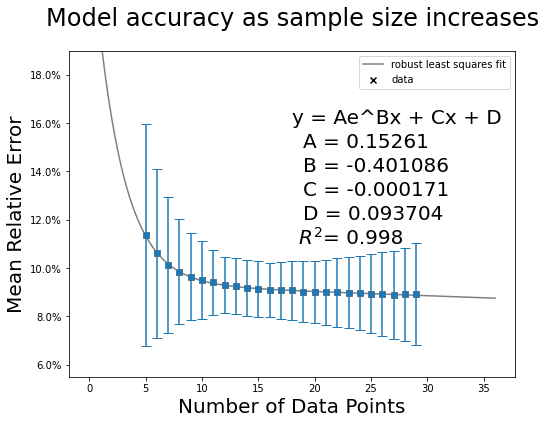

In [25]:
from matplotlib.ticker import PercentFormatter

# plot results with raw coefficients 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.set_facecolor('xkcd:white')
#fig.patch.set_facecolor('xkcd:light gray')
plt.scatter(D_err[:,0],D_err[:,1], label='data', marker="x", color="black")
# using std error for the error bars
#plt.errorbar(D_err[:,0],D_err[:,1], yerr=D_err[:,4], fmt='o',capsize=5)
# using standard deviation for the error bars
plt.errorbar(D_err[:,0],D_err[:,1], yerr=D_err[:,3], fmt='o',capsize=5)
plt.plot(xlinD1, ylinDrls, label='robust least squares fit', color="gray")
plt.xlabel('Number of Data Points', fontsize=font2)
plt.ylabel('Mean Relative Error', fontsize=font2)
ax.set_title('Model accuracy as sample size increases', fontsize=font1, pad=25)
plt.ylim(.055,.19)
#plt.ylim(0,.25)
plt.legend(loc="upper right")
txt_strtY = .16
txt_strtX = 18

#plt.text(min(D_err[:,0]+2), max(D_err[:,1]), MSEr, {'fontsize': font2})
plt.text(txt_strtX, txt_strtY, "y = Ae^Bx + Cx + D", {'fontsize': font2})
plt.text(txt_strtX+1, txt_strtY-.010, A_txt, {'fontsize': font2})
plt.text(txt_strtX+1, txt_strtY-.020, B_txt, {'fontsize': font2})
plt.text(txt_strtX+1, txt_strtY-.030, C_txt, {'fontsize': font2})
plt.text(txt_strtX+1, txt_strtY-.04, D_txt, {'fontsize': font2})
plt.text(txt_strtX+.5, txt_strtY-.05, (r'$R^2$'), {'fontsize': font2})
plt.text(txt_strtX+2.75, txt_strtY-.05, DNAr3, {'fontsize': font2})

ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))


In [26]:
def errorModel(xVal):
    return res_robust.x[0]*(np.exp(res_robust.x[1]*xVal))+res_robust.x[2]*xVal+res_robust.x[3]

In [27]:
# estimate the error margin for the entire dataframe
errMargin = errorModel(38)
errMargin

0.08718796371032933

In [29]:
# custom function to numerically find the sample size necessary to hit a specific error percentage based on the error model
# input arguments are the guess for what the x might be, and the y target range

def numericalErrFinder(y_target, x_target, currentErr=100):

    x_guess = copy.copy(x_target)
    x_init = x_target-5
    x_final = x_target+5

# for the range from x_init to x_final
    for i in range(x_init-1,x_final+1):
        # if the difference between the calculated errorModel at this i and the desired error is less than the current error (defaults to 100)
        if abs((errorModel(i))-y_target) < currentErr:
            # replace the CurrentErr with this new calculated error
            currentErr = abs((errorModel(i))-y_target) 
            # and set the current guess to the value in the range
            x_guess = i
#            print(currentErr)
#            print(x_guess)

    # if the current guess is equal to the lowest or highest bound, recursively call this function 
    if (x_guess == x_final or x_guess == x_init-1):
        x_guess = numericalErrFinder(y_target, x_guess, currentErr)
    
    return x_guess

In [30]:
# use the error finder to estimate the amount of points necessary to achieve an error margin of 5%
numericalErrFinder(0.05, 44)

255

In [31]:
# use the error finder to estimate the amount of points necessary to achieve an error margin of 1%
numericalErrFinder(0.01, 200)

488

In [32]:
# use the error finder to estimate the amount of points necessary to achieve an error margin of 0%
numericalErrFinder(0.00, 450)

546

In [33]:
# estimate error on the curve fitting for the mean relative error by bootstrapping the data

# set the number of sample runs
n_iter = 10000

# create placeholders for the mean, variance, and standard deviation at each data point for each iteration
error_calc1 = np.zeros((n_iter,4))  # error calculations using the variance as the limits for selecting data
error_calc2 = np.zeros((n_iter,4))  # error calcs using the standard deviation


for j in range(n_iter):
    # create a placeholder for the new generated dataset
    coef_err = np.zeros((D_err.shape[0],3))  
    for i in range(D_err.shape[0]):
        # copy the x data point
        coef_err[i][0] = D_err[i][0]
        # draw a random point within the standard error
        coef_err[i][1] = random.randint(-100,100)/100*D_err[i][4]+D_err[i][1]
        # draw a random point within the standard deviation
        coef_err[i][2] = random.randint(-100,100)/100*D_err[i][3]+D_err[i][1]

    # create a robust least squares model based on variance dataset
    res_robust_bs1 = least_squares(fun, abNought, loss='soft_l1', f_scale=0.1, args=(coef_err[:,0],coef_err[:,1]))
    # create a robust least squares model based on standard deviation dataset
    res_robust_bs2 = least_squares(fun, abNought, loss='soft_l1', f_scale=0.1, args=(coef_err[:,0],coef_err[:,2]))

    # capture the calculated model coefficients
    for i in range(4):
        error_calc1[j][i]=res_robust_bs1.x[i]
        error_calc2[j][i]=res_robust_bs2.x[i]
        
#    print(error_calc1)
#    print(error_calc2)

# hold stats on error spread
final_err1 = np.zeros((4,4))
final_err2 = np.zeros((4,4))


for i in range(4):
    # calculate mean, variance, standard deviation, and standard error
    final_err1[i][0]=np.mean(error_calc1[:,i])
    final_err1[i][1]=statistics.variance(error_calc1[:,i])
    final_err1[i][2]=np.std(error_calc1[:,i])
    final_err1[i][3]=np.std(error_calc1[:,i])/(np.sqrt(D_err.shape[0]-1))
    # smooth any of the data points that are extreme outliers from fitting errors in the std dev set
    xTx100 = np.asarray([k for k in error_calc2[:,i] if (abs(k) < 10)])
    final_err2[i][0]=np.mean(xTx100)
    final_err2[i][1]=statistics.variance(xTx100)
    final_err2[i][2]=np.std(xTx100)
    final_err2[i][3]=np.std(xTx100)/(np.sqrt(len(xTx100)))

print("standard error-based bootstrap")
print("mean - var - stddev - std err")
print(final_err1)
print("standard deviation-based bootstrap")
print("mean - var - stddev - std err")
print(final_err2)

standard error-based bootstrap
mean - var - stddev - std err
[[ 1.52904848e-01  5.88077775e-05  7.66823948e-03  1.56527283e-03]
 [-4.01197330e-01  8.51704621e-05  9.22832298e-03  1.88372354e-03]
 [-1.71444799e-04  5.02558927e-11  7.08878460e-06  1.44699210e-06]
 [ 9.37028618e-02  2.54290223e-08  1.59456826e-04  3.25489884e-05]]
standard deviation-based bootstrap
mean - var - stddev - std err
[[ 1.02561018e+00  5.77995183e+00  2.40391834e+00  3.35892203e-02]
 [-3.42389845e+00  1.08972257e+01  3.30092957e+00  3.30092957e-02]
 [ 9.94191188e-04  3.50318598e-05  5.91847587e-03  5.91847587e-05]
 [-9.90689365e-02  1.02939520e+00  1.01454042e+00  1.01454042e-02]]


In [34]:
##### print the std err error 
A_txt2 = round(final_err1[0][3],6)
B_txt2 = round(final_err1[1][3],6)
C_txt2 = round(final_err1[2][3],6)
D_txt2 = round(final_err1[3][3],6)

print(A_txt2)
print(B_txt2)
print(C_txt2)
print(D_txt2)


0.001565
0.001884
1e-06
3.3e-05


In [35]:
# print the coefficients at the correct sig fig based on error
A_coef = str(round(res_robust.x[0],3))
B_coef = str(round(res_robust.x[1],3))
C_coef = str(round(res_robust.x[2],6))
#C_coef = str("{0:.1e}".format(round(res_robust.x[2],6)))
D_coef = str(round(res_robust.x[3],5))

# create a string for the equation
MSEr = "y = "+ A_coef + " e^(" + B_coef + " x) " + C_coef+ "x +" + D_coef
print(MSEr)

A_txt = "A = " + A_coef 
B_txt = "B = " + B_coef 
C_txt = "C = " + C_coef
D_txt = "D = " + D_coef

y = 0.153 e^(-0.401 x) -0.000171x +0.0937


In [36]:
# create strings for the coefficients and their respective errors

print("coefficients and errors:")

A_test1 = "A = ("+str(int(round(res_robust.x[0],3)*1000))
AE_test1 = str(int(round(final_err1[0][3],3)*1000))+")x10" 
AE_test2 = "-3"
print(A_test1, "+/-",AE_test1,AE_test2 )

B_test1 = "B = ("+str(int(round(res_robust.x[1],3)*1000))
BE_test1 = str(int(round(final_err1[1][3],3)*1000))+")x10" 
BE_test2 = "-3"
print(B_test1, "+/-",BE_test1,BE_test2 )

C_test1 = "C = ("+str(int(round(res_robust.x[2],6)*1000000))
CE_test1 = str(int(round(final_err1[2][3],6)*1000000))+")x10" 
CE_test2 = "-6"
print(C_test1, "+/-",CE_test1,CE_test2 )

D_test1 = "D = ("+str(int(round(res_robust.x[3],5)*100000))
DE_test1 = str(int(round(final_err1[3][3],5)*100000))+")x10" 
DE_test2 = "-5"

print(D_test1, "+/-",DE_test1,DE_test2 )

# but recall that we're plotting against a percentage for visual ease, so we have to multiply the y values by 100

print("coefficients and errors (for plotting vs. whole percentage):")

A_test1 = "A = ("+str(int(round(res_robust.x[0],3)*1000))
AE_test1 = str(int(round(final_err1[0][3],3)*1000))+")x10" 
AE_test2 = "-1"
print(A_test1, "+/-",AE_test1,AE_test2 )

B_test1 = "B = ("+str(int(round(res_robust.x[1],3)*1000))
BE_test1 = str(int(round(final_err1[1][3],3)*1000))+")x10" 
BE_test2 = "-1"
print(B_test1, "+/-",BE_test1,BE_test2 )

C_test1 = "C = ("+str(int(round(res_robust.x[2],6)*1000000))
CE_test1 = str(int(round(final_err1[2][3],6)*1000000))+")x10" 
CE_test2 = "-4"
print(C_test1, "+/-",CE_test1,CE_test2 )

D_test1 = "D = ("+str(int(round(res_robust.x[3],5)*100000))
DE_test1 = str(int(round(final_err1[3][3],5)*100000))+")x10" 
DE_test2 = "-3"

print(D_test1, "+/-",DE_test1,DE_test2 )

coefficients and errors:
A = (153 +/- 2)x10 -3
B = (-401 +/- 2)x10 -3
C = (-171 +/- 1)x10 -6
D = (9370 +/- 3)x10 -5
coefficients and errors (for plotting vs. whole percentage):
A = (153 +/- 2)x10 -1
B = (-401 +/- 2)x10 -1
C = (-171 +/- 1)x10 -4
D = (9370 +/- 3)x10 -3


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


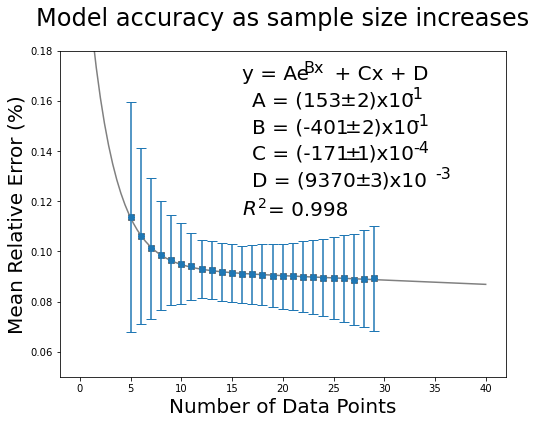

In [37]:
# plot results for standard error-based points and standard deviation-based error in MRE

# create the data strings for the plot from the std err error 
#A_txt2 = str(round(final_err1[0][2],2))
#B_txt2 = str(round(final_err1[1][2],2))
#C_txt2 = str(round(final_err1[2][2],5))
#D_txt2 = str(round(final_err1[3][2],4))
#D_txt2 = str("{0:.1e}".format(final_err1[3][2]))

# create the figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.set_facecolor('xkcd:white')
plt.scatter(D_err[:,0],D_err[:,1], label='data', marker="x", color="black")
# using standard error for the error bars
#plt.errorbar(D_err[:,0],D_err[:,1], yerr=D_err[:,4], fmt='o',capsize=5)
#y_f=.11
#y_i=.07
#txt_strtY = max(D_err[:,1])+.0035

# using standard deviation for the error bars
plt.errorbar(D_err[:,0],D_err[:,1], yerr=D_err[:,3], fmt='o',capsize=5)
y_f=.18
y_i=.05
txt_strtY = max(D_err[:,1])+.055

y_int = y_f-y_i
y_pct = 0.0818

# generate plot data for least squares and robust least squares
xlinD1 = np.linspace(0,40, 100)
ylinDrls = (res_robust.x[0]*np.exp(res_robust.x[1]*xlinD1))+res_robust.x[2]*xlinD1+res_robust.x[3]


plt.plot(xlinD1, ylinDrls, label='robust least squares fit', color="gray")
plt.xlabel('Number of Data Points', fontsize=font2)
plt.ylabel('Mean Relative Error (%)', fontsize=font2)
ax.set_title('Model accuracy as sample size increases', fontsize=font1, pad=25, fontname='Helvetica')

plt.ylim(y_i,y_f)
#plt.legend(loc="upper right")
txt_strtX = min(D_err[:,0]+11)

# add the formula for the curve fit along with the errors
plt.text(txt_strtX, txt_strtY, "y = Ae    + Cx + D", {'fontsize': font2})
plt.text(txt_strtX+6, txt_strtY+.262*(y_pct*y_int), "Bx", {'fontsize': font3})
plt.text(txt_strtX+1, txt_strtY-y_pct*y_int, A_test1, {'fontsize': font2})
plt.text(txt_strtX+9.5, txt_strtY-y_pct*y_int, (r'$\pm$'), {'fontsize': font2})
plt.text(txt_strtX+11.25, txt_strtY-y_pct*y_int, AE_test1, {'fontsize': font2})
plt.text(txt_strtX+16.25, (txt_strtY-y_pct*y_int)+.262*(y_pct*y_int), AE_test2, {'fontsize': font3})

plt.text(txt_strtX+1, txt_strtY-y_pct*y_int*2, B_test1, {'fontsize': font2})
plt.text(txt_strtX+10, txt_strtY-y_pct*y_int*2, (r'$\pm$'), {'fontsize': font2})
plt.text(txt_strtX+11.75, txt_strtY-y_pct*y_int*2, BE_test1, {'fontsize': font2})
plt.text(txt_strtX+16.90, (txt_strtY-y_pct*y_int*2)+.262*(y_pct*y_int), BE_test2, {'fontsize': font3})

plt.text(txt_strtX+1, txt_strtY-y_pct*y_int*3, C_test1, {'fontsize': font2})
plt.text(txt_strtX+10, txt_strtY-y_pct*y_int*3, (r'$\pm$'), {'fontsize': font2})
plt.text(txt_strtX+11.25, txt_strtY-y_pct*y_int*3, CE_test1, {'fontsize': font2})
plt.text(txt_strtX+16.90, (txt_strtY-y_pct*y_int*3)+.262*(y_pct*y_int), CE_test2, {'fontsize': font3})

plt.text(txt_strtX+1, txt_strtY-y_pct*y_int*4, D_test1, {'fontsize': font2})
plt.text(txt_strtX+11, txt_strtY-y_pct*y_int*4, (r'$\pm$'), {'fontsize': font2})
plt.text(txt_strtX+12.50, txt_strtY-y_pct*y_int*4, DE_test1, {'fontsize': font2})
plt.text(txt_strtX+19, (txt_strtY-y_pct*y_int*4)+.262*(y_pct*y_int), DE_test2, {'fontsize': font3})

plt.text(txt_strtX, txt_strtY-y_pct*y_int*5.1, (r'$R^2$'), {'fontsize': font2})
plt.text(txt_strtX+2.5, txt_strtY-y_pct*y_int*5.1, DNAr3, {'fontsize': font2})

#ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
#fig.savefig("Item1-DNA vs T model Rarification.png")
#fig.savefig("Item1-DNA vs T model Rarification.svg")

In [38]:
objects2 = np.arange(8)*50
y_pos = objects2/100
y_pos

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5])

([<matplotlib.axis.XTick at 0x1432a02a160>,
 [Text(0.0, 0, '1'),
  Text(1.3010299956639813, 0, '20'),
  Text(1.6989700043360187, 0, '50'),
  Text(2.0, 0, '100'),
  Text(2.3979400086720375, 0, '250'),
  Text(2.6989700043360187, 0, '500')])

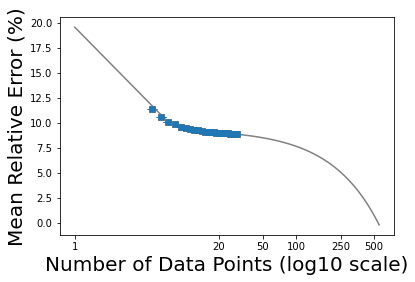

In [39]:
# generate plot data for least squares and robust least squares for the space from 0 to projected 0% error
xlinD1 = np.linspace(1,558, 100)
ylinDrls = (res_robust.x[0]*np.exp(res_robust.x[1]*xlinD1))+res_robust.x[2]*xlinD1+res_robust.x[3]

XOMFG = np.log10(xlinD1)
YOMFG = ylinDrls*100

plt.scatter(np.log10(D_err[:,0]),D_err[:,1]*100, label='data', marker="x", color="black")
# using standard error for the error bars
plt.errorbar(np.log10(D_err[:,0]),D_err[:,1]*100, yerr=D_err[:,4], fmt='o',capsize=5)
#txt_strtY = max(D_err[:,1])+.0035


plt.plot(XOMFG, YOMFG, label='robust least squares fit', color="gray")
plt.xlabel('Number of Data Points (log10 scale)', fontsize=font2)
plt.ylabel('Mean Relative Error (%)', fontsize=font2)
ax.set_title('Model accuracy as sample size increases', fontsize=font1, pad=25, fontname='Helvetica')

#plt.ylim(y_i,y_f)
#plt.legend(loc="upper right")
txt_strtX = min(D_err[:,0]+11)

objectsx = [1,20,50,100,250,500]
objectsx[0]=1
x_pos = np.log10(objectsx)
plt.xticks(x_pos, objectsx)


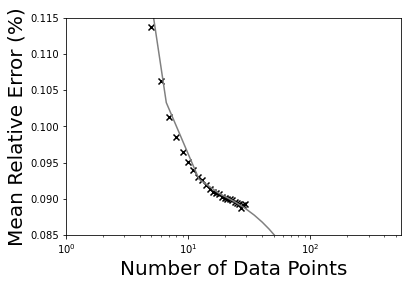

In [40]:
# generate plot data for least squares and robust least squares
xlinD1 = np.linspace(1,558, 100)
ylinDrls = (res_robust.x[0]*np.exp(res_robust.x[1]*xlinD1))+res_robust.x[2]*xlinD1+res_robust.x[3]

plt.scatter(D_err[:,0],D_err[:,1], label='data', marker="x", color="black")

plt.plot(xlinD1, ylinDrls, label='robust least squares fit', color="gray")
plt.xlabel('Number of Data Points', fontsize=font2)
plt.ylabel('Mean Relative Error (%)', fontsize=font2)
ax.set_title('Model accuracy as sample size increases', fontsize=font1, pad=25, fontname='Helvetica')

#plt.ylim(y_i,y_f)
#plt.legend(loc="upper right")
txt_strtX = min(D_err[:,0]+11)
plt.xlim(1,550)
plt.ylim(.085,.115)
plt.xscale("log")

In [41]:
# fit the mean relative error data to an exponential decay model

# Define the function computing residuals for least-squares minimization:
# y = a*e^(bx) + c, with ab as a vector of len 4 holding the initial guesses for those coefficients
def fun(ab, x1, MSE):
    return (ab[0]*np.exp(ab[1]*x1))+ab[2]-MSE


# use an estimate for a starting point
abNought = [1,1,1]

# robust least squares model (less prone to outlier error)
res_robust = least_squares(fun, abNought, loss='soft_l1', f_scale=0.1, args=(D_err[:,0],D_err[:,1]))

# generate plot data for least squares and robust least squares
xlinD1 = np.linspace(0,36, 150)
ylinDrls = (res_robust.x[0]*np.exp(res_robust.x[1]*xlinD1))+res_robust.x[2]

# create an array to hold the coefficients
MSE_coeff = np.zeros(3)
for i in range(3):
    MSE_coeff[i]=round(res_robust.x[i],3)

# create text string for the function using calculated coefficients
A_coef = str(round(res_robust.x[0],6))
B_coef = str(round(res_robust.x[1],6))
C_coef = str(round(res_robust.x[2],6))
#D_coef = str("{0:.1E}".format(res_robust.x[3]))

A_txt = "A = " + A_coef 
B_txt = "B = " + B_coef 
C_txt = "C = " + C_coef

MSEr = "y = "+ A_coef + " e^(" + B_coef + " x) " + C_coef
print(MSEr)

# find r-squared
r2_y1rls = res_robust.x[0]*(np.exp(res_robust.x[1]*D_err[:,0]))+res_robust.x[2]
DNAr3= '= ' + str(round(r2_score(D_err[:,1], r2_y1rls),3))

print('R-squared, robust least squares: %.4f' % r2_score(D_err[:,1], r2_y1rls))

y = 0.101667 e^(-0.297831 x) 0.089717
R-squared, robust least squares: 0.9913


In [42]:
def errorModel(xVal):
    return res_robust.x[0]*(np.exp(res_robust.x[1]*xVal))+res_robust.x[2]

In [43]:
# estimate the error margin for the entire dataframe
errMargin = errorModel(38)
errMargin

0.08971774629068197

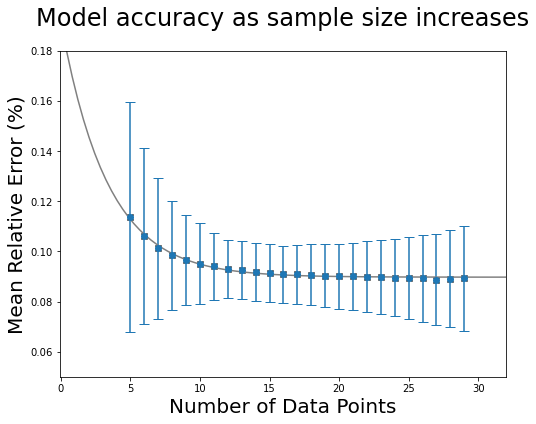

In [44]:
# plot results for standard error-based points and standard deviation-based error in MRE

# create the data strings for the plot from the std err error 
#A_txt2 = str(round(final_err1[0][2],2))
#B_txt2 = str(round(final_err1[1][2],2))
#C_txt2 = str(round(final_err1[2][2],5))
#D_txt2 = str(round(final_err1[3][2],4))
#D_txt2 = str("{0:.1e}".format(final_err1[3][2]))

# create the figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.set_facecolor('xkcd:white')
plt.scatter(D_err[:,0],D_err[:,1], label='data', marker="x", color="black")
# using standard error for the error bars
#plt.errorbar(D_err[:,0],D_err[:,1], yerr=D_err[:,4], fmt='o',capsize=5)
#y_f=.11
#y_i=.07
#txt_strtY = max(D_err[:,1])+.0035

# using standard deviation for the error bars
plt.errorbar(D_err[:,0],D_err[:,1], yerr=D_err[:,3], fmt='o',capsize=5)
y_f=.18
y_i=.05
txt_strtY = max(D_err[:,1])+.055

y_int = y_f-y_i
y_pct = 0.0818

# generate plot data for least squares and robust least squares
xlinD1 = np.linspace(0,40, 100)
ylinDrls = (res_robust.x[0]*np.exp(res_robust.x[1]*xlinD1))+res_robust.x[2]


plt.plot(xlinD1, ylinDrls, label='robust least squares fit', color="gray")
plt.xlabel('Number of Data Points', fontsize=font2)
plt.ylabel('Mean Relative Error (%)', fontsize=font2)
ax.set_title('Model accuracy as sample size increases', fontsize=font1, pad=25, fontname='Helvetica')

plt.ylim(y_i,y_f)
plt.xlim(-.1,32)
#plt.legend(loc="upper right")
txt_strtX = min(D_err[:,0]+11)



In [45]:
# estimate error on the curve fitting for the mean relative error by bootstrapping the data

# set the number of sample runs
n_iter = 10000

# create placeholders for the mean, variance, and standard deviation at each data point for each iteration
error_calc1 = np.zeros((n_iter,4))  # error calculations using the variance as the limits for selecting data
error_calc2 = np.zeros((n_iter,4))  # error calcs using the standard deviation


for j in range(n_iter):
    # create a placeholder for the new generated dataset
    coef_err = np.zeros((D_err.shape[0],3))  
    for i in range(D_err.shape[0]):
        # copy the x data point
        coef_err[i][0] = D_err[i][0]
        # draw a random point within the standard error
        coef_err[i][1] = random.randint(-100,100)/100*D_err[i][4]+D_err[i][1]
        # draw a random point within the standard deviation
        coef_err[i][2] = random.randint(-100,100)/100*D_err[i][3]+D_err[i][1]

    # create a robust least squares model based on variance dataset
    res_robust_bs1 = least_squares(fun, abNought, loss='soft_l1', f_scale=0.1, args=(coef_err[:,0],coef_err[:,1]))
    # create a robust least squares model based on standard deviation dataset
    res_robust_bs2 = least_squares(fun, abNought, loss='soft_l1', f_scale=0.1, args=(coef_err[:,0],coef_err[:,2]))

    # capture the calculated model coefficients
    for i in range(3):
        error_calc1[j][i]=res_robust_bs1.x[i]
        error_calc2[j][i]=res_robust_bs2.x[i]
        
#    print(error_calc1)
#    print(error_calc2)

# hold stats on error spread
final_err1 = np.zeros((4,4))
final_err2 = np.zeros((4,4))


for i in range(4):
    # calculate mean, variance, standard deviation, and standard error
    final_err1[i][0]=np.mean(error_calc1[:,i])
    final_err1[i][1]=statistics.variance(error_calc1[:,i])
    final_err1[i][2]=np.std(error_calc1[:,i])
    final_err1[i][3]=np.std(error_calc1[:,i])/(np.sqrt(D_err.shape[0]-1))
    # smooth any of the data points that are extreme outliers from fitting errors in the std dev set
    xTx100 = np.asarray([k for k in error_calc2[:,i] if (abs(k) < 10)])
    final_err2[i][0]=np.mean(xTx100)
    final_err2[i][1]=statistics.variance(xTx100)
    final_err2[i][2]=np.std(xTx100)
    final_err2[i][3]=np.std(xTx100)/(np.sqrt(len(xTx100)))

print("standard error-based bootstrap")
print("mean - var - stddev - std err")
print(final_err1)
print("standard deviation-based bootstrap")
print("mean - var - stddev - std err")
print(final_err2)

standard error-based bootstrap
mean - var - stddev - std err
[[ 1.01770479e-01  8.41644302e-06  2.90096559e-03  5.92157122e-04]
 [-2.97926766e-01  1.78674953e-05  4.22678466e-03  8.62788805e-04]
 [ 8.97164626e-02  1.16778240e-09  3.41711226e-05  6.97515120e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
standard deviation-based bootstrap
mean - var - stddev - std err
[[ 7.21084994e-01  3.58349558e+00  1.89285517e+00  2.43879280e-02]
 [-2.28739061e+00  7.84694598e+00  2.80110001e+00  2.80110001e-02]
 [ 7.54806245e-03  5.09279573e-01  7.13602002e-01  7.19380250e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [46]:
##### print the std deviation error 
A_txt2 = round(final_err1[0][2],6)
B_txt2 = round(final_err1[1][2],6)
C_txt2 = round(final_err1[2][2],6)

print(A_txt2)
print(B_txt2)
print(C_txt2)

0.002901
0.004227
3.4e-05


In [47]:
# print the coefficients at the correct sig fig based on error
A_coef = str(round(res_robust.x[0],3))
B_coef = str(round(res_robust.x[1],3))
C_coef = str(round(res_robust.x[2],5))

# create a string for the equation
MSEr = "y = "+ A_coef + " e^(" + B_coef + " x) " + C_coef
print(MSEr)

A_txt = "A = " + A_coef 
B_txt = "B = " + B_coef 
C_txt = "C = " + C_coef

y = 0.102 e^(-0.298 x) 0.08972


In [48]:
# create strings for the coefficients and their respective standard deviation

print("coefficients and errors:")

A_test1 = "A = ("+str(int(round(res_robust.x[0],3)*1000))
AE_test1 = str(int(round(final_err1[0][2],3)*1000))+")x10" 
AE_test2 = "-3"
print(A_test1, "+/-",AE_test1,AE_test2 )

B_test1 = "B = ("+str(int(round(res_robust.x[1],3)*1000))
BE_test1 = str(int(round(final_err1[1][2],3)*1000))+")x10" 
BE_test2 = "-3"
print(B_test1, "+/-",BE_test1,BE_test2 )

C_test1 = "C = ("+str(int(round(res_robust.x[2],5)*100000))
CE_test1 = str(int(round(final_err1[2][2],5)*100000))+")x10" 
CE_test2 = "-5"
print(C_test1, "+/-",CE_test1,CE_test2 )

# but recall that we're plotting against a percentage for visual ease, so we have to multiply the y values by 100

print("coefficients and errors (for plotting vs. whole percentage):")

A_test1 = "A = ("+str(int(round(res_robust.x[0],3)*1000))
AE_test1 = str(int(round(final_err1[0][2],3)*1000))+")x10" 
AE_test2 = "-1"
print(A_test1, "+/-",AE_test1,AE_test2 )

B_test1 = "B = ("+str(int(round(res_robust.x[1],3)*1000))
BE_test1 = str(int(round(final_err1[1][2],3)*1000))+")x10" 
BE_test2 = "-1"
print(B_test1, "+/-",BE_test1,BE_test2 )

C_test1 = "C = ("+str(int(round(res_robust.x[2],5)*100000))
CE_test1 = str(int(round(final_err1[2][2],5)*100000))+")x10" 
CE_test2 = "-3"
print(C_test1, "+/-",CE_test1,CE_test2 )


coefficients and errors:
A = (102 +/- 3)x10 -3
B = (-298 +/- 4)x10 -3
C = (8972 +/- 3)x10 -5
coefficients and errors (for plotting vs. whole percentage):
A = (102 +/- 3)x10 -1
B = (-298 +/- 4)x10 -1
C = (8972 +/- 3)x10 -3


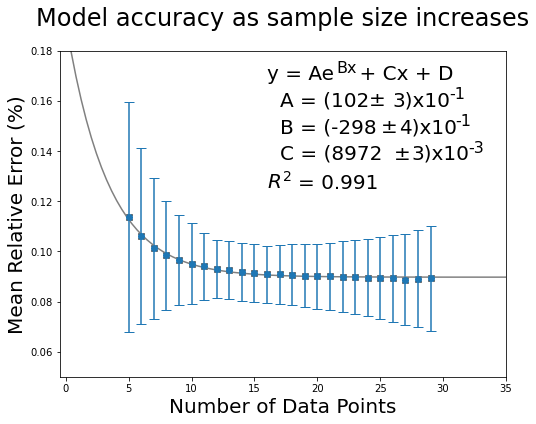

In [49]:
# plot results for standard error-based points and standard deviation-based error in MRE

# create the figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.set_facecolor('xkcd:white')
plt.scatter(D_err[:,0],D_err[:,1], label='data', marker="x", color="black")
# using standard error for the error bars
#plt.errorbar(D_err[:,0],D_err[:,1], yerr=D_err[:,4], fmt='o',capsize=5)
#y_f=.11
#y_i=.07
#txt_strtY = max(D_err[:,1])+.0035

# using standard deviation for the error bars
plt.errorbar(D_err[:,0],D_err[:,1], yerr=D_err[:,3], fmt='o',capsize=5)
y_f=.18
y_i=.05
txt_strtY = max(D_err[:,1])+.055

y_int = y_f-y_i
y_pct = 0.0818

# generate plot data for least squares and robust least squares
xlinD1 = np.linspace(0,40, 100)
ylinDrls = (res_robust.x[0]*np.exp(res_robust.x[1]*xlinD1))+res_robust.x[2]


plt.plot(xlinD1, ylinDrls, label='robust least squares fit', color="gray")
plt.xlabel('Number of Data Points', fontsize=font2)
plt.ylabel('Mean Relative Error (%)', fontsize=font2)
ax.set_title('Model accuracy as sample size increases', fontsize=font1, pad=25, fontname='Helvetica')

plt.ylim(y_i,y_f)
plt.xlim(-.5,35)
#plt.legend(loc="upper right")
txt_strtX = min(D_err[:,0]+11)

# add the formula for the curve fit along with the errors
plt.text(txt_strtX, txt_strtY, "y = Ae    + Cx + D", {'fontsize': font2})
plt.text(txt_strtX+5.5, txt_strtY+.262*(y_pct*y_int), "Bx", {'fontsize': font3})
plt.text(txt_strtX+1, txt_strtY-y_pct*y_int, A_test1, {'fontsize': font2})
plt.text(txt_strtX+8, txt_strtY-y_pct*y_int, (r'$\pm$'), {'fontsize': font2})
plt.text(txt_strtX+10, txt_strtY-y_pct*y_int, AE_test1, {'fontsize': font2})
plt.text(txt_strtX+14.5, (txt_strtY-y_pct*y_int)+.262*(y_pct*y_int), AE_test2, {'fontsize': font3})

plt.text(txt_strtX+1, txt_strtY-y_pct*y_int*2, B_test1, {'fontsize': font2})
plt.text(txt_strtX+9, txt_strtY-y_pct*y_int*2, (r'$\pm$'), {'fontsize': font2})
plt.text(txt_strtX+10.5, txt_strtY-y_pct*y_int*2, BE_test1, {'fontsize': font2})
plt.text(txt_strtX+15, (txt_strtY-y_pct*y_int*2)+.262*(y_pct*y_int), BE_test2, {'fontsize': font3})

plt.text(txt_strtX+1, txt_strtY-y_pct*y_int*3, C_test1, {'fontsize': font2})
plt.text(txt_strtX+10, txt_strtY-y_pct*y_int*3, (r'$\pm$'), {'fontsize': font2})
plt.text(txt_strtX+11.5, txt_strtY-y_pct*y_int*3, CE_test1, {'fontsize': font2})
plt.text(txt_strtX+16, (txt_strtY-y_pct*y_int*3)+.262*(y_pct*y_int), CE_test2, {'fontsize': font3})

plt.text(txt_strtX, txt_strtY-y_pct*y_int*4.1, (r'$R^2$'), {'fontsize': font2})
plt.text(txt_strtX+2.5, txt_strtY-y_pct*y_int*4.1, DNAr3, {'fontsize': font2})

#ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
fig.savefig("Item1-DNA vs T model Rarification.png")
fig.savefig("Item1-DNA vs T model Rarification.svg")

In [11]:
# saves kernel state
# note that all csv_writer functions are commented out, since they cannot be pickled
import dill
dill.dump_session('item1_update.db')

In [7]:
## load kernel state
#import dill
#dill.load_session('item1_update.db')